In [9]:
import deeplay as dl
import numpy as np
from deeplay.applications.detection.lodestar.transforms import *
import numpy as np
import torch
from utils.train.generator import generate_particle
import matplotlib.pyplot as plt

**Generated training data at different z-positions vs experimental data**<br>
Particle size = 45nm - 55nm<br>
Particle resolution = 65 nm  

(-0.5, 366.5, 367.5, -0.5)

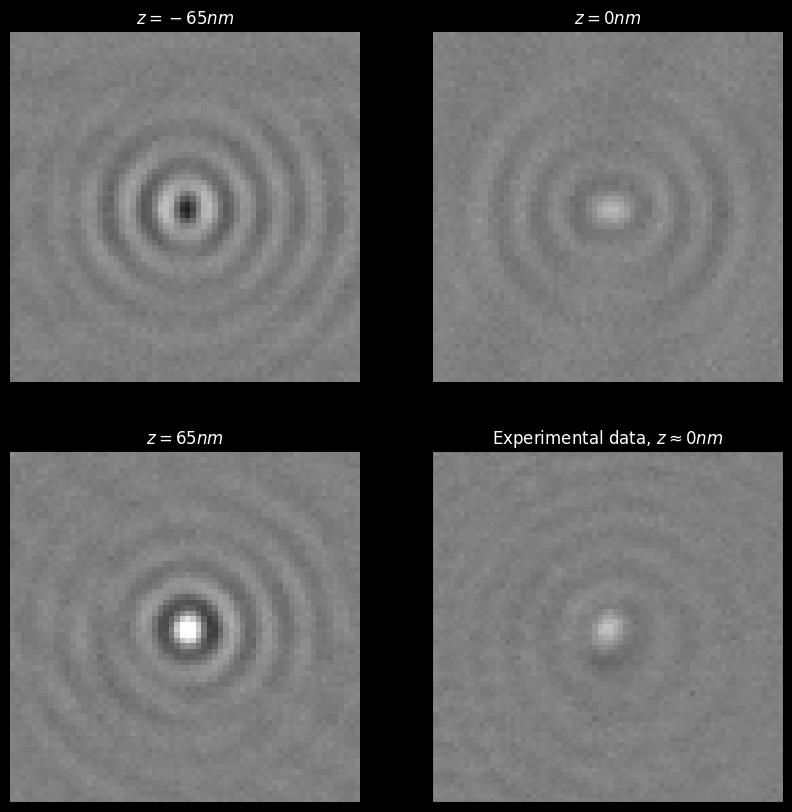

In [10]:
image_size = 64

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(generate_particle(image_size, z = -1), cmap='gray', vmin=-1.5, vmax=1.5)
axs[0,0].set_title(r'$z = -65 nm$')
axs[0,0].axis('off')

axs[0,1].imshow(generate_particle(image_size, z = 0), cmap='gray', vmin=-1.5, vmax=1.5)
axs[0,1].set_title(r'$z = 0 nm$')
axs[0,1].axis('off')

axs[1,0].imshow(generate_particle(image_size, z = 1), cmap='gray', vmin=-1.5, vmax=1.5)
axs[1,0].set_title(r'$z = 65 nm$')
axs[1,0].axis('off')

#load experimental data
image = plt.imread('utils/train/partikel.png')

axs[1,1].imshow(image, cmap='gray')
axs[1,1].set_title(r'Experimental data, $z \approx 0 nm$')
axs[1,1].axis('off')


**Additional transformations that are added to the LodeSTAR method:**

In [11]:
# additional_transforms.py
class RandomTranslationZ(Transform):
    def __init__(self, dz=lambda: np.random.uniform(-3, 3)):
        indices = (2,)
        super().__init__(self._forward, self._backward, dz=dz, indices=indices)

    @staticmethod 
    def _forward(x, dz, indices):

        radius = lambda: np.random.uniform(45e-9, 55e-9)
        polarization_angle = lambda: np.random.rand() * 2 * np.pi

        batch_size = x.shape[0]
        color_channels = 1 # DeepTrack creates grayscale images
        # image_size = 64 # already defined in above cell
        
        transformed = torch.empty((batch_size, color_channels, image_size, image_size))

        for i, dz_one in enumerate(dz):
            image = generate_particle(image_size, z = float(dz_one), 
                                    radius=radius, 
                                    polarization_angle=polarization_angle)
            image = torch.tensor(image).permute(2, 0, 1)
            transformed[i] = image
            
        return transformed.to(x.device)
        
    @staticmethod
    def _backward(x, dz, indices):
        sub_v = torch.zeros_like(x)
        sub_v[:, indices[-1]] = dz
        return x - sub_v

class RandomScaleImage(Transform):
    def __init__(self, scale=lambda: np.random.uniform(0.8, 1.2)):
        super().__init__(self._forward, self._backward, scale=scale)

    @staticmethod
    def _forward(x, scale):
        return x * scale.view(-1, 1, 1, 1).to(x.device)

    @staticmethod
    def _backward(x, scale):
        return x

**Trainer class:**

In [12]:
# lodestar3dtrainer.py
class LodeSTAR3DTrainer:

    def __init__(self,
                 epochs=1000,
                 batch_size=10,
                 num_transforms=8,
                 learning_rate= 1e-4,
                 device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                 model=None
                 ):
    
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_transforms = num_transforms
        self.learning_rate = learning_rate
        self.device = device
        self.model = model.to(self.device)
        self.num_outputs = 3
        self.losses = []

        self.lodestar = dl.LodeSTAR(model = self.model,
                                    num_outputs = self.num_outputs,
                                    n_transforms = self.num_transforms,
                                    transforms = Transforms([
                                                            RandomTranslationZ(),
                                                            RandomTranslation2d(),
                                                            RandomRotation2d(),
                                                            RandomScaleImage(),
                                                            ]))
        self.model = self.lodestar._get_default_model() if model == None else model
    
    def train(self, image_size = 64, lower_loss_bound = None):
        print(f"Using device: {self.device}")
        self.losses = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        dataloader = torch.utils.data.DataLoader(dataset = 
                                                 torch.empty((self.batch_size, image_size, image_size)).to(self.device))

        for epoch in range(1, self.epochs+1):

            for sample in dataloader:
                transforms, inverses = self.lodestar.transform_data(sample)
                prediction = self.lodestar.forward(transforms)
                loss_dict = self.lodestar.compute_loss(prediction, inverses)
                loss1, loss2 = loss_dict['between_image_disagreement'], loss_dict['within_image_disagreement']
                loss = loss1 + loss2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                self.losses.append(loss.item())

            if lower_loss_bound != None:
                if self.losses[epoch] < lower_loss_bound and self.losses[epoch-1] < lower_loss_bound:
                    print(f"Epoch {epoch}/{self.epochs} \tLoss: {self.losses[-1]}")
                    print(f"Lower loss bound of {lower_loss_bound} reached. Stopping training.")
                    break
        
            if epoch % 2 == 0:
                print(f"Epoch {epoch}/{self.epochs} \tLoss: {self.losses[-1]}", end='\r')
        
    def plot_losses(self, yscale='linear'):
        plt.scatter([i for i in list(range(1, len(self.losses)+1))], self.losses, s=1, color='black')
        plt.grid()
        plt.yscale(yscale)
        plt.show()

In [14]:
from utils.CNN_model import CNN # Standard CNN used for the LodeSTAR model

trainer = LodeSTAR3DTrainer(model = CNN(),
                            batch_size=10,
                            epochs = 1000,)

trainer.train(lower_loss_bound=None) # set lower_loss_bound = 1 for early stopping

Using device: cuda


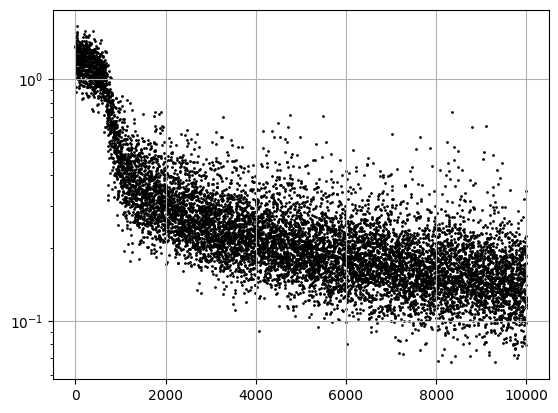

In [17]:
trainer.plot_losses(yscale='log')

**Testing the model for x and y accuracy on generated data**

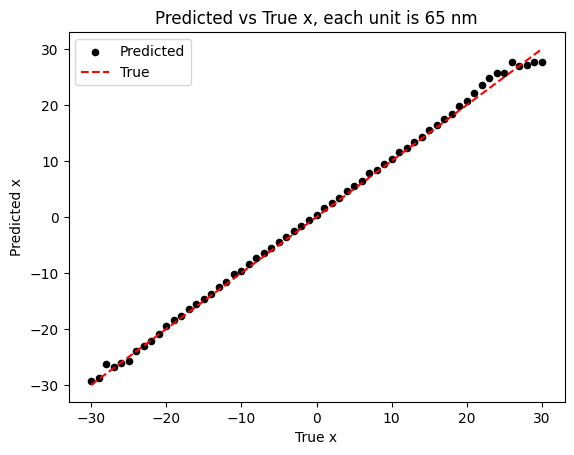

In [18]:
device = trainer.device

coordinates_x = list(range(-30, 31))
images_x = [generate_particle(position=(x,np.random.uniform(-30,30)), z= np.random.uniform(-3,3)) for x in coordinates_x]
images_x = [torch.tensor(image).float().permute(2, 0, 1) for image in images_x]

predicted_x = [trainer.lodestar.pooled(image.unsqueeze(0))[0] for image in images_x]

plt.scatter(coordinates_x, [x[0].detach().cpu() for x in predicted_x], label='Predicted', s=20, color='black')
plt.plot(coordinates_x, coordinates_x, label='True', color='red', linestyle='--')
plt.xlabel('True x')
plt.ylabel('Predicted x')
plt.title('Predicted vs True x, each unit is 65 nm')
plt.legend()
plt.show()

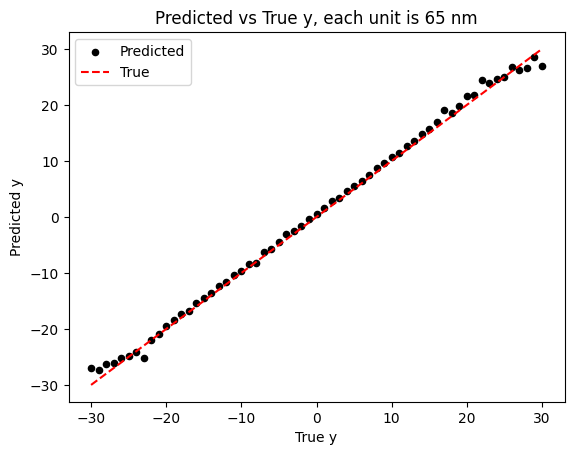

In [19]:
coordinates_y = list(range(-30, 31))
images_y = [generate_particle(position=(np.random.uniform(-30,30),y), z= np.random.uniform(-3,3)) for y in coordinates_y]
images_y = [torch.tensor(image).float().permute(2, 0, 1) for image in images_y]

predicted_y = [trainer.lodestar.pooled(image.unsqueeze(0))[0] for image in images_y]

plt.scatter(coordinates_y, [y[1].detach().cpu() for y in predicted_y], label='Predicted', s=20, color='black')
plt.plot(coordinates_x, coordinates_x, label='True', color='red', linestyle='--')
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.title('Predicted vs True y, each unit is 65 nm')
plt.legend()
plt.show()

**Testing relative z coordinate accuracy**

In [20]:
z_range = 3
number_of_points = 100

coordinates_z = list(np.linspace(-z_range, z_range, number_of_points))
images_z = [generate_particle(position=(np.random.uniform(-5,5),np.random.uniform(-5,5)), z = z) for z in coordinates_z]
images_z = [torch.tensor(image).float().permute(2, 0, 1) for image in images_z]

predicted_z = [trainer.lodestar.pooled(image.unsqueeze(0))[0] for image in images_z]

Do linear regression on predicted_z to calculate z-offset

C:\Users\aramj\AppData\Local\Temp\ipykernel_9924\3653907457.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(regressor.intercept_)


Text(0, 0, 'z = 1.00 * z + 2.79')

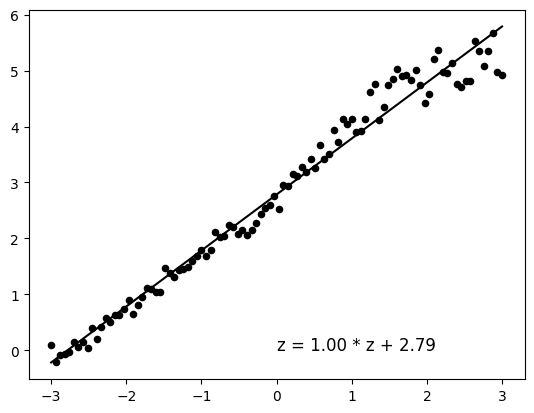

In [21]:

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(np.array(coordinates_z).reshape(-1,1), np.array([z[2].detach().cpu() for z in predicted_z]).reshape(-1,1))
slope = float(regressor.coef_[0][0])
intercept = float(regressor.intercept_)

plt.scatter(coordinates_z, [z[2].detach().cpu() for z in predicted_z], label='Predicted', s=20, color='black')
plt.plot(coordinates_z, [slope * z + intercept for z in coordinates_z], label='Predicted', color='black')
plt.text(0, 0, f'z = {slope:.2f} * z + {intercept:.2f}', fontsize=12)

Define correction parameter wich is equal to the intercept

In [22]:
correction = intercept

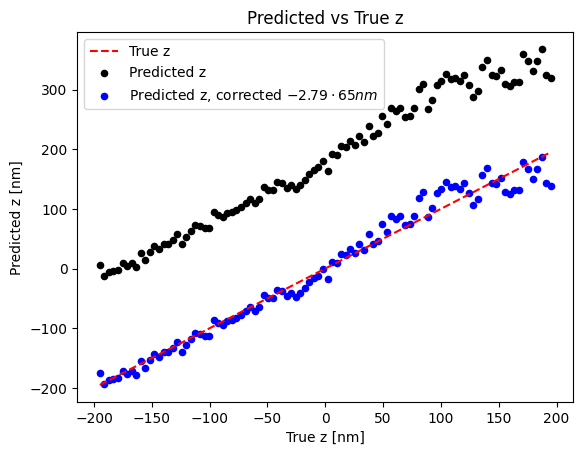

In [23]:
coordinates_z_nm = [z*65 for z in coordinates_z]
plt.plot(coordinates_z_nm, coordinates_z_nm, label='True z', color='red', linestyle='--')
plt.scatter(coordinates_z_nm, [z[-1].detach().cpu()*65 for z in predicted_z], label='Predicted z', s=20, color='black')
plt.scatter(coordinates_z_nm, [z[-1].detach().cpu()*65 - correction*65  for z in predicted_z], label=f'Predicted z, corrected $-{correction:.2f} \cdot 65nm$', s=20, color='blue')
plt.xlabel('True z [nm]')
plt.ylabel('Predicted z [nm]')
plt.title('Predicted vs True z')
plt.legend()
plt.show()

**Save the model for future use**

In [24]:
save_path = r'saved_models\lodestar3d_example.pth'
torch.save(trainer.model.state_dict(), save_path)